In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set()
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy
import numpy as np
import os
import pandas as pd
import sys
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Define and run the mixture density network

### signal dataset

In [3]:
cd /home/xupeng/projects/signal

/home/xupeng/projects/signal


In [6]:
sys.path.append('bin')

In [7]:
from utils import prepare_dataset, preprocess,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture

In [8]:
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


In [9]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
        Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
        '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6,
                 n_components=4,
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output],
                               self.logsigma_min,
                               self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_output)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_output)
        pi = self.softmax(x[:, (self.n_components*self.n_output*2):])
        xpi = pi+ 1e-3
        ypi= xpi/xpi.sum(dim=-1, keepdim=True)
        logpi = torch.log(ypi)
        logpi = logpi.view(-1, self.n_components)
        return logpi, logsigma, mu

In [10]:
n_components= 20
model = MixtureDensityNetwork(n_input=24, n_output=2,  n_components = n_components,n_hiddens=[22, 20, 18],
                             logsigma_min=-2, logsigma_max=1)
optimizer = optim.Adam(model.parameters())
model

MixtureDensityNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=18, bias=True)
    (5): ReLU()
    (6): Linear(in_features=18, out_features=100, bias=True)
  )
  (softmax): Softmax()
)

In [11]:
X_train.shape,y_train.shape

((750, 24), (750, 2))

## scale data to deal with loss exploding problem

In [12]:
# create data loaders
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess_zscore(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = 10
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)

X_train.shape = (750, 24) X_test.shape = (250, 24)


/home/xupeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/xupeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/xupeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/xupeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [191]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)
    
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
dir_name = time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S")
path_model = os.path.join('models/', dir_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)
torch.save(model.state_dict(), path_model+'model')

HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

[Epoch 0] train loss: 1.3635980765, test loss: 1.18536683083
[Epoch 10] train loss: -0.828147383928, test loss: -0.732955250144
[Epoch 20] train loss: -0.944970548153, test loss: -0.848822315931
[Epoch 30] train loss: -0.984236541589, test loss: -0.867240434289
[Epoch 40] train loss: -1.00764444749, test loss: -0.858400526047
[Epoch 50] train loss: -1.01301159064, test loss: -0.811643688977
[Epoch 60] train loss: -1.0171383063, test loss: -0.863449126482
[Epoch 70] train loss: -1.03146681388, test loss: -0.861569274962
[Epoch 80] train loss: -1.03167099396, test loss: -0.874450853169
[Epoch 90] train loss: -1.03366854429, test loss: -0.890577912331
[Epoch 100] train loss: -1.03549397628, test loss: -0.898803068399
[Epoch 110] train loss: -1.04590262334, test loss: -0.860868190527
[Epoch 120] train loss: -1.03535627445, test loss: -0.870642186403
[Epoch 130] train loss: -1.04509784857, test loss: -0.895577815175
[Epoch 140] train loss: -1.0448951141, test loss: -0.885118480921
[Epoch 15

[Epoch 1230] train loss: -1.07509644349, test loss: -0.938757545948
[Epoch 1240] train loss: -1.0745112896, test loss: -0.939341843128
[Epoch 1250] train loss: -1.07018386682, test loss: -0.935255906582
[Epoch 1260] train loss: -1.07399158796, test loss: -0.925472295284
[Epoch 1270] train loss: -1.07354049842, test loss: -0.931556191444
[Epoch 1280] train loss: -1.0738090388, test loss: -0.934351024628
[Epoch 1290] train loss: -1.07400551955, test loss: -0.929279384613
[Epoch 1300] train loss: -1.07046504815, test loss: -0.934977607727
[Epoch 1310] train loss: -1.07150674025, test loss: -0.936224470139
[Epoch 1320] train loss: -1.07389588197, test loss: -0.92999478817
[Epoch 1330] train loss: -1.07298113982, test loss: -0.93725466013
[Epoch 1340] train loss: -1.06735734463, test loss: -0.927524797916
[Epoch 1350] train loss: -1.07280342579, test loss: -0.927120778561
[Epoch 1360] train loss: -1.06895609697, test loss: -0.94038693428
[Epoch 1370] train loss: -1.07595441182, test loss: -

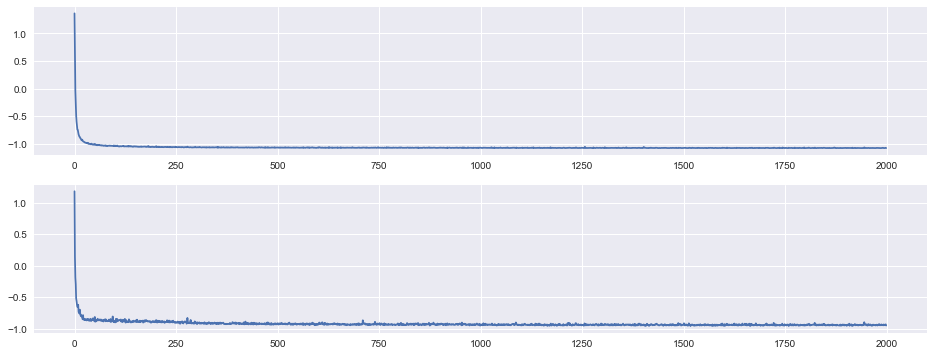

In [192]:
fig,ax=plt.subplots(2,1,figsize=(16,6))
ax[0].plot(np.array([trainlosses[i] for i in range(len(trainlosses))]))
ax[1].plot(np.array([testlosses[i] for i in range(len(testlosses))]))

In [193]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
logpi_pred.size(), logsigma_pred.size(), mu_pred.size()
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)
pi_reversed.shape, sigma_reversed.shape, mu_reversed.shape

((250, 20), (250, 20, 2), (250, 20, 2))

In [99]:
def get_prediction(pi,mu,sigma,n_components):
    model = IsotropicGaussianMixture(n_components, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [195]:
ind = 10
get_prediction(pi_reversed[ind], mu_reversed[ind],sigma_reversed[ind],n_components)

(array([8.68956237]), array([[-0.82187599,  0.25157949]]))

In [98]:
def plot_result(ax,ind,n_components=20):
    gaussianmodel = IsotropicGaussianMixture(n_components, n_dim=2)
    gaussianmodel.set_params(pi_reversed[ind],  mu_reversed[ind], sigma_reversed[ind])
    X_grid, Y_grid = np.mgrid[-2:2:0.02, -2:2:0.02]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    modes = gaussianmodel.find_modes(n_init=10)
    #print ('modes',modes)
    print ('p_modes',gaussianmodel.pdf(modes))
    ax.contour(X_grid, Y_grid, gaussianmodel.pdf(X).reshape(X_grid.shape), 
                   linewidths=0.5, levels=np.linspace(0, 1, 80))
    ax.set_title('sample '+str(ind))

In [205]:
mu_reversed.shape

(250, 20, 2)

In [206]:
np.array([mu_reversed[i] for i in range(250)])

array([[[-0.15059021, -0.783522  ],
        [-0.15187606, -0.78607357],
        [-0.15202492, -0.78461164],
        ...,
        [-0.15116556, -0.78482705],
        [-0.15183666, -0.783879  ],
        [-0.15048389, -0.78455484]],

       [[-0.68380183,  0.67557776],
        [-0.68408126,  0.6722326 ],
        [-0.68421483,  0.674314  ],
        ...,
        [-0.683856  ,  0.6740893 ],
        [-0.68472415,  0.67439175],
        [-0.6831613 ,  0.6741034 ]],

       [[ 1.4772437 ,  0.03877265],
        [ 1.478065  ,  0.03534095],
        [ 1.4764409 ,  0.03703204],
        ...,
        [ 1.4780953 ,  0.03770766],
        [ 1.4753678 ,  0.0375062 ],
        [ 1.4772843 ,  0.03732933]],

       ...,

       [[-0.8617359 , -0.32033554],
        [-0.8632931 , -0.3233916 ],
        [-0.8629817 , -0.32148513],
        ...,
        [-0.862567  , -0.32195032],
        [-0.86273944, -0.3210724 ],
        [-0.86138934, -0.32159698]],

       [[ 1.4855865 , -1.2472684 ],
        [ 1.4847795 , -1.25

In [207]:
np.array([sigma_reversed[i] for i in range(250)]).reshape(-1,2).shape

(5000, 2)

([array([4.996e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00]),
  array([4.994e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.0

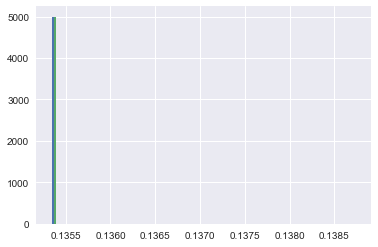

In [208]:
hist(np.array([sigma_reversed[i] for i in range(250)]).reshape(-1,2),bins=50)

('p_modes', array([8.68956237]))
('p_modes', array([1.59729185e-32, 8.68956470e+00]))
('p_modes', array([8.14569933e-35]))
('p_modes', array([8.68956392e+00, 2.87235016e-39]))
('p_modes', array([8.68956450e+00, 2.89858889e-16]))
('p_modes', array([5.66245427e-11, 8.68956400e+00]))
('p_modes', array([8.68956431e+00, 6.44926952e-36]))
('p_modes', array([4.77113981e-13, 8.68956289e+00]))
('p_modes', array([8.68956278e+00, 4.69789815e-19]))
('p_modes', array([8.68956407e+00, 3.38783509e-20]))
('p_modes', array([8.59965607e-34, 8.68956484e+00]))
('p_modes', array([8.68956741]))
('p_modes', array([1.26430494e-18]))
('p_modes', array([8.6895645]))
('p_modes', array([8.68956439e+00, 3.83227886e-42]))
('p_modes', array([1.86953892e-26, 8.68956453e+00]))


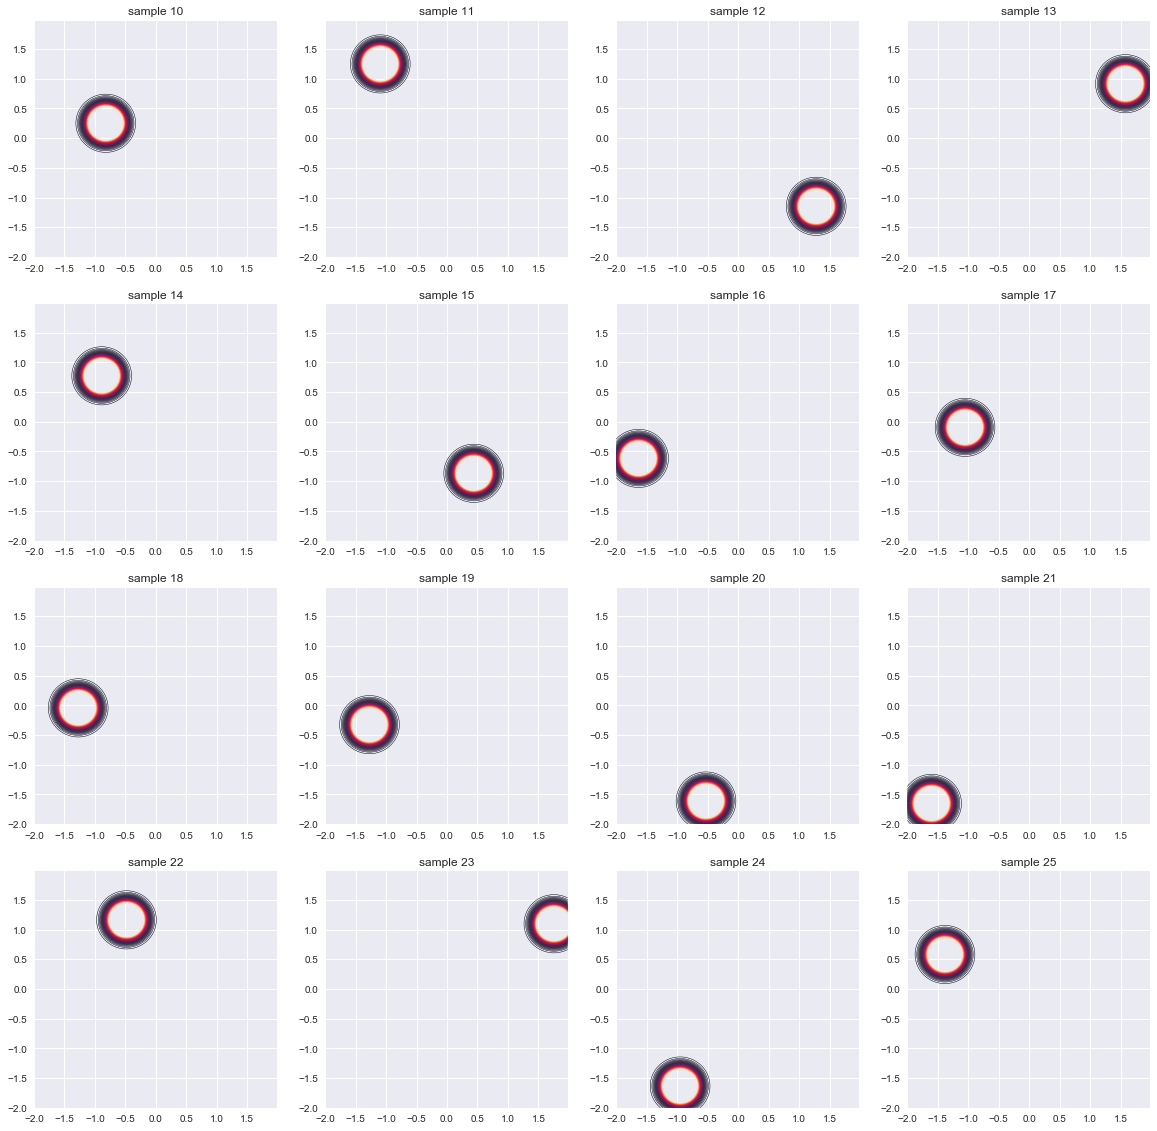

In [209]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        plot_result(ax[i,j],10+i*4+j)

In [210]:
prediction_xy = np.ndarray([250,2])
probabes = np.ndarray([250])
for i in tqdm(range(250)):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],n_components)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [312]:
def plot_arrow(y_testdata,y_test):
    fig,ax=plt.subplots(1,figsize=(9,9))
    c = np.sum(y_testdata**2+y_test**2,axis=1)
    ax.scatter(y_testdata[:,0],y_testdata[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    ax.scatter(y_test[:,0],y_test[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    #ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    xorigin = y_testdata[:,0].ravel()
    yorigin = y_testdata[:,1].ravel()
    dx = y_test[:,0].ravel()-y_testdata[:,0].ravel()
    dy = y_test[:,1].ravel()-y_testdata[:,1].ravel()
    print (xorigin.shape, yorigin.shape, dx.shape, dy.shape)
    ax.arrow(xorigin[2], yorigin[2], dx[2], dy[2], color = 'b')
    for i in range(y_testdata.shape[0]):
        ax.arrow(y_testdata[i,0],y_testdata[i,1],
            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')
#for i in range(y_testdata.shape[0]):
#    ax.arrow(y_testdata[i,0],y_testdata[i,1],
#            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')

In [213]:
y_test.shape

(250, 2)

((250,), (250,), (250,), (250,))


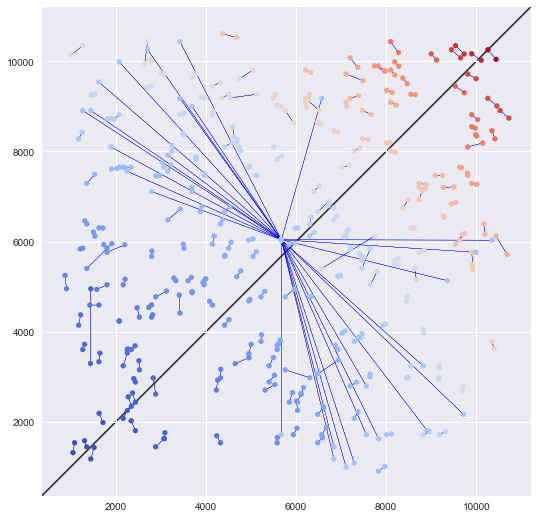

In [214]:
report_metrics(prediction_xy_reverse,y_test)
plot_arrow(prediction_xy_reverse,y_test)

(array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 223.]),
 array([5.33252624e-51, 8.68956760e-01, 1.73791352e+00, 2.60687028e+00,
        3.47582704e+00, 4.34478380e+00, 5.21374056e+00, 6.08269732e+00,
        6.95165408e+00, 7.82061084e+00, 8.68956760e+00]),
 <a list of 10 Patch objects>)

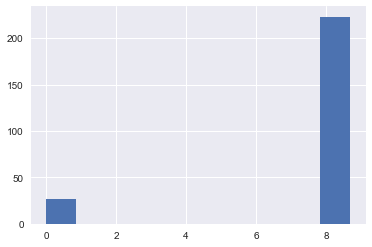

In [215]:
hist(probabes)

In [216]:
import pickle, h5py, time, argparse, itertools, datetime
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy
import numpy as np
import os

In [226]:
data_name = 'data_6'
n_components =6
batchsize =10
earlystopping_epoch_nums=20
nhidden1=22
nhidden2=20
nhidden3=18
logsigma_min = -2
logsigma_max =1

In [218]:
from utils import prepare_dataset, preprocess,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture

In [220]:
X_train, X_test, y_train, y_test = prepare_dataset(featurename=data_name)

In [221]:
model = MixtureDensityNetwork(n_input=24, n_output=2,  n_components = n_components,
                              n_hiddens=[nhidden1, nhidden2, nhidden3],
                             logsigma_min=logsigma_min, logsigma_max=logsigma_max )
optimizer = optim.Adam(model.parameters())

In [108]:
# create data loaders
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess_zscore(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = batchsize
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape,
     'y_train.shape =', y_train.shape, 'y_test.shape =', y_test.shape)

NameError: name 'batchsize' is not defined

In [231]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)
    
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    ###### early stop to avoid unnecessary training######
    if epoch >=200:
        if epoch%10 == 0:
            recentlossmin = np.min(np.array([testlosses[i] for i in np.arange(epoch-earlystopping_epoch_nums,epoch)]))
            otherlossmin = np.min(np.array([testlosses[i] for i in np.arange(0,epoch-earlystopping_epoch_nums)]))
            print (recentlossmin,otherlossmin)
            if recentlossmin > otherlossmin: # no longer decrease
                print ('exist at epoch:' +str(epoch))
                break
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
dir_name = ('batch_'+str(batchsize)+'_gaussian_'+str(n_components)+
            '_datatype_'+data_name+'_batch_'+str(batchsize)+'_earlyepoch_'+str(earlystopping_epoch_nums))
print dir_name
path_model = os.path.join('models/', dir_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)
torch.save(model.state_dict(), path_model+'/model')

HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

[Epoch 0] train loss: -1.06831654867, test loss: -0.916253258586
[Epoch 10] train loss: -1.06803993225, test loss: -0.934752194881
[Epoch 20] train loss: -1.07181910038, test loss: -0.929882294536
[Epoch 30] train loss: -1.06770717144, test loss: -0.925072163343
[Epoch 40] train loss: -1.07076227029, test loss: -0.930380038619
[Epoch 50] train loss: -1.06755313873, test loss: -0.929969555736
[Epoch 60] train loss: -1.07238934517, test loss: -0.927740150392
[Epoch 70] train loss: -1.06951699893, test loss: -0.928523500189
[Epoch 80] train loss: -1.0708927695, test loss: -0.94979927659
[Epoch 90] train loss: -1.07273093224, test loss: -0.936233529449
[Epoch 100] train loss: -1.06997886817, test loss: -0.926201520562
[Epoch 110] train loss: -1.06819523017, test loss: -0.931423989534
[Epoch 120] train loss: -1.06733302752, test loss: -0.922227134407
[Epoch 130] train loss: -1.07295165539, test loss: -0.92124573946
[Epoch 140] train loss: -1.06670186838, test loss: -0.922308366895
[Epoch 15

In [232]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)

In [233]:
def get_prediction(pi,mu,sigma,n_components):
    model = IsotropicGaussianMixture(n_components, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [234]:
prediction_xy = np.ndarray([250,2])
probabes = np.ndarray([250])
for i in tqdm(range(250)):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],n_components)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [235]:
parametersinfo = np.array([data_name,str(n_components),str(batchsize),str(earlystopping_epoch_nums),
str(nhidden1),str(nhidden2),str(nhidden3),str(logsigma_min),str(logsigma_max)])

In [242]:
np.savetxt(path_model+'/rmse.txt',np.array([report_metrics(prediction_xy_reverse,y_test)[0]]))
np.savetxt(path_model+'/pcc.txt',np.array([report_metrics(prediction_xy_reverse,y_test)[1][0]]))
np.savetxt(path_model+'/probabse.txt',probabes)
np.savetxt(path_model+'/parameters.txt',parametersinfo,fmt="%s")

- data whole rss aoa toa data_4 data_5 data_6
- n_components 2-20
- batch 5-30 5
- early_epoch 10 100
- nhidden1 20-30
- nhidden2 15-25
- nhidden3 10-20
- logsigmamin -10 -1
- logsigmamax 1 5

python test_parameters.py --data whole --n_components 10 --batch 20 --early_epoch 20 --nhidden1 20 --nhidden2 18 --nhidden3 16 --logsigmamin 2 --logsigmamax 2

python test_parameters.py --data whole --n_components 10 --batch 20 --early_epoch 20 --nhidden1 20 --nhidden2 18 --nhidden3 16 --logsigmamin 2 --logsigmamax 2

In [ ]:
7 9 7 5 5 5 5

In [1]:
453600 *90 /3600/24

472

In [ ]:
{
COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 4 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER
} | parallel -P 1

### parrallel sbatch

In [ ]:
#!/bin/bash
# add all other SBATCH directives here...

#SBATCH -p cox
#SBATCH --gres=gpu:0
#SBATCH --constraint=titanx
#SBATCH -n 16  # Number of cores
#SBATCH -N 1 # Ensure that all cores are on one machine
#SBATCH --mem=50000
#SBATCH -t 2-00:00:00
#SBATCH -o logs/train_%j.log
#SBATCH -e logs/signal.err # STDERR

{
COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 2 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python bin/test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER
} | parallel -P 16

In [39]:
7* 7 *6 *5* 5 * 6 *10 * 90/10/3600/24

45

并行着处理ncomponents 从2到20 在rc上/n/coxfs01/xupeng/projects/signal

COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 4 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER

In [10]:
import os
import numpy as np

In [15]:
cd signal/

/Users/james/signal


In [31]:
np.loadtxt('models/'+i+'/paras/rmse.txt').ravel()[0]

1252.4546172272992

In [136]:
filenames = np.loadtxt('models/filename.txt',dtype='str')

In [138]:
rmsesss = []
names = []
for i in tqdm(filenames):
    try:
#       print (np.loadtxt('models/'+i+'/paras/rmse.txt'))
        rmsesss.append(np.loadtxt('models/'+i+'/paras/rmse.txt').ravel()[0])
        names.append(i)   
    except:
        print ('no such file: '+i)
#print (np.sort(rmsesss))
save = np.ndarray([len(rmsesss),2]).astype('S256')
for i in tqdm(range(len(rmsesss))):
    save[i,0] = names[i]
    save[i,1] = str(rmsesss[i])
np.savetxt('rmses.txt',save,fmt='%s')
print ('tested condition nums: '+str((len(os.listdir('models/')))) )
print ("minimum:  "+str(np.min(rmsesss)))

HBox(children=(IntProgress(value=0, max=15618), HTML(value=u'')))

no such file: batch_5_gaussian_12_datatype_whole_batch_5_earlyepoch_60_nhidden_1_24_logsigma_min_max_-4_5
no such file: batch_5_gaussian_14_datatype_whole_batch_5_earlyepoch_100_nhidden_1_24_logsigma_min_max_-3_1
no such file: batch_5_gaussian_18_datatype_whole_batch_5_earlyepoch_40_nhidden_1_20_logsigma_min_max_-3_1
no such file: batch_5_gaussian_20_datatype_whole_batch_5_earlyepoch_100_nhidden_1_26_logsigma_min_max_-4_3
no such file: batch_5_gaussian_6_datatype_whole_batch_5_earlyepoch_60_nhidden_1_24_logsigma_min_max_-3_2



HBox(children=(IntProgress(value=0, max=15613), HTML(value=u'')))


tested condition nums: 15620
minimum:  170.18074446648535


In [139]:
np.min(rmsesss)

170.18074446648535

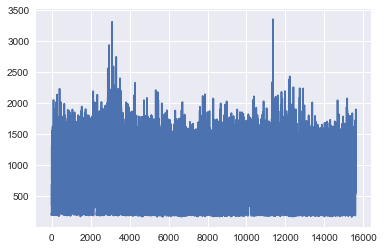

In [140]:
plot(rmsesss)

In [141]:
pwd

u'/Users/james/signal'

In [142]:
rmsess = np.loadtxt('rmses.txt',dtype='str')

(array([2.100e+03, 5.820e+02, 1.610e+02, 1.520e+02, 2.610e+02, 6.510e+02,
        9.020e+02, 6.190e+02, 2.680e+02, 2.060e+02, 2.400e+02, 3.480e+02,
        4.400e+02, 5.800e+02, 7.480e+02, 9.990e+02, 1.042e+03, 1.114e+03,
        1.024e+03, 8.110e+02, 6.920e+02, 5.450e+02, 3.860e+02, 2.490e+02,
        1.860e+02, 1.000e+02, 5.900e+01, 4.400e+01, 2.600e+01, 3.000e+01,
        1.400e+01, 1.000e+01, 1.000e+01, 3.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 170.18074447,  233.95132522,  297.72190597,  361.49248672,
         425.26306747,  489.03364822,  552.80422897,  616.57480972,
         680.34539047,  744.11597122,  807.88655197,  871.65713273,
         935.42771348,  999.19829423, 1062.96887498, 1126.73945573,
        1190.51003648, 1254.28061723, 1318.05119798, 1381.82177873,
        1445.59235948, 1509.36294023

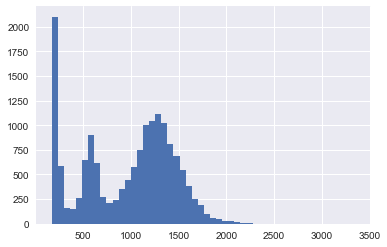

In [143]:
hist(rmsess[:,1].astype('float'),bins=50)

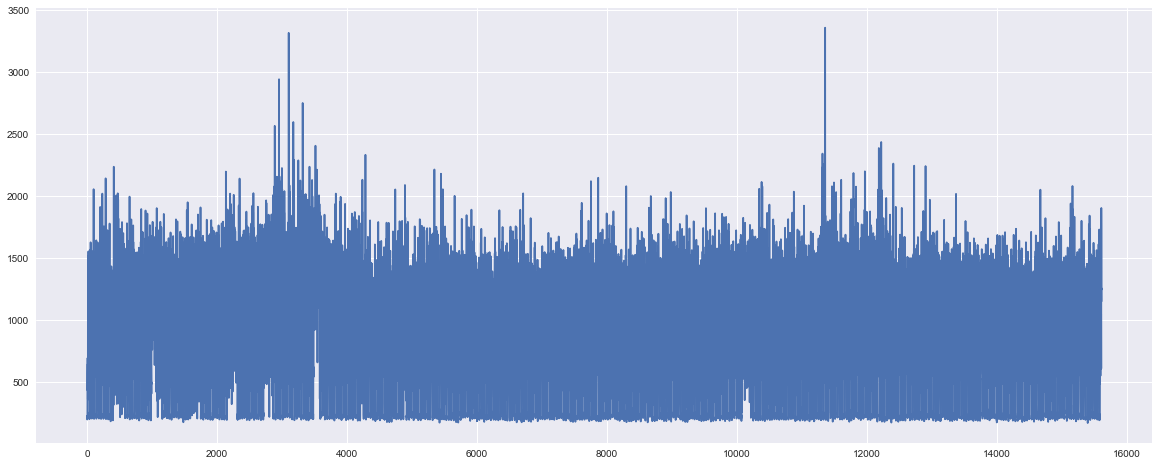

In [144]:
fig,ax=plt.subplots(1,figsize=(20,8))
ax.plot(rmsess[:,1].astype('float'))

In [145]:
rmsess[:,0][2000]

'batch_10_gaussian_16_datatype_whole_batch_10_earlyepoch_40_nhidden_1_20_logsigma_min_max_-6_4'

(array([ 1.,  6.,  3.,  2.,  6.,  1.,  6.,  5.,  7.,  3.,  7.,  1.,  5.,
         5., 12.,  5.,  5.,  9.,  8.,  6., 16., 12.,  5.,  7., 11.,  8.,
        11.,  9., 14., 10., 10., 12.,  2., 12.,  8., 12., 10.,  4.,  4.,
        16., 10.,  9., 14., 11.,  4., 11.,  8.,  9.,  4.,  9.]),
 array([3.000000e+00, 3.145400e+02, 6.260800e+02, 9.376200e+02,
        1.249160e+03, 1.560700e+03, 1.872240e+03, 2.183780e+03,
        2.495320e+03, 2.806860e+03, 3.118400e+03, 3.429940e+03,
        3.741480e+03, 4.053020e+03, 4.364560e+03, 4.676100e+03,
        4.987640e+03, 5.299180e+03, 5.610720e+03, 5.922260e+03,
        6.233800e+03, 6.545340e+03, 6.856880e+03, 7.168420e+03,
        7.479960e+03, 7.791500e+03, 8.103040e+03, 8.414580e+03,
        8.726120e+03, 9.037660e+03, 9.349200e+03, 9.660740e+03,
        9.972280e+03, 1.028382e+04, 1.059536e+04, 1.090690e+04,
        1.121844e+04, 1.152998e+04, 1.184152e+04, 1.215306e+04,
        1.246460e+04, 1.277614e+04, 1.308768e+04, 1.339922e+04,
        1.37

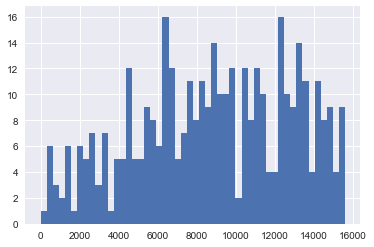

In [146]:
hist(np.where(rmsess[:,1].astype('float') <=200),bins=50)

In [147]:
indunder200 = np.where(rmsess[:,1].astype('float') <=200)[0]

In [148]:
#batch, ncomponents,datatype,earlyepoch,nhidden1,logsigmamin,logsigmamax
np.array(rmsess[:,0][2000].split('_'))[np.array([1,3,5,9,12,16,17])]

array(['10', '16', 'whole', '40', '20', '-6', '4'], dtype='|S10')

In [149]:
paras = np.ndarray([indunder200.shape[0],8]).astype('str')
for i in range(paras.shape[0]):
    paras[i][:7] = np.array(rmsess[:,0][indunder200[i]].split('_'))[np.array([1,3,5,9,12,16,17])]
    paras[i][7] = np.round(rmsess[:,1][indunder200[i]].astype('float'),2).astype('str')

In [150]:
paradata = pd.DataFrame(paras,columns=np.array(['batch','n_gaussian','data','earlystop','nhidden1','sigmamin','sigmamax','RMSE']))

Text(0.5,1,u'RMSE distribution, total condistions: 15613')

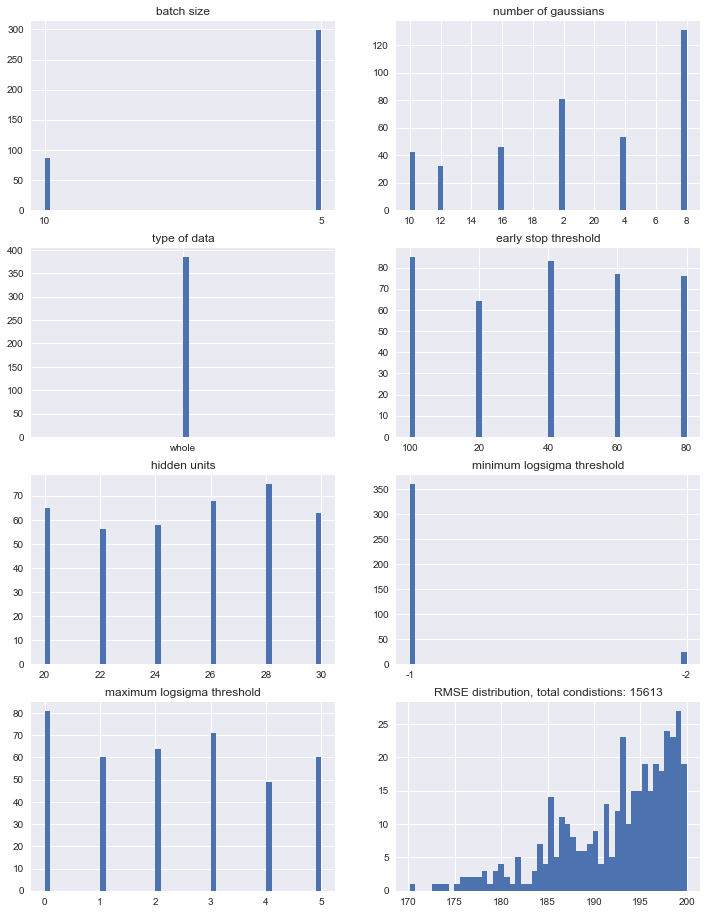

In [151]:
fig,ax=plt.subplots(4,2,figsize=(12,16))
ax[0,0].hist(paradata['batch'],bins=50)
ax[0,0].set_title('batch size')
ax[0,1].hist(paradata['n_gaussian'],bins=50)
ax[0,1].set_title('number of gaussians')
ax[1,0].hist(paradata['data'],bins=50)
ax[1,0].set_title('type of data')
ax[1,1].hist(paradata['earlystop'],bins=50)
ax[1,1].set_title('early stop threshold')
ax[2,0].hist(paradata['nhidden1'],bins=50)
ax[2,0].set_title('hidden units')
ax[2,1].hist(paradata['sigmamin'],bins=50)
ax[2,1].set_title('minimum logsigma threshold')
ax[3,0].hist(paradata['sigmamax'],bins=50)
ax[3,0].set_title('maximum logsigma threshold')
ax[3,1].hist(rmsess[:,1][indunder200].astype('float'),bins=50)
ax[3,1].set_title('RMSE distribution, total condistions: '+str(rmsess.shape[0]))

In [264]:
rmsess[indneed][0]

'batch_10_gaussian_6_datatype_whole_batch_10_earlyepoch_40_nhidden_1_30_logsigma_min_max_-1_3'

In [282]:
bestparas

array(['whole', '2', '10', '20', '24', '22', '20', '-4', '0'], dtype='|S5')

In [323]:
rmsess[indneed][0]

'batch_10_gaussian_6_datatype_whole_batch_10_earlyepoch_40_nhidden_1_30_logsigma_min_max_-1_3'

In [338]:
rmsess[:,0]

array(['batch_10_gaussian_10_datatype_whole_batch_10_earlyepoch_20_nhidden_1_20_logsigma_min_max_-1_0',
       'batch_10_gaussian_10_datatype_whole_batch_10_earlyepoch_20_nhidden_1_20_logsigma_min_max_-1_1',
       'batch_10_gaussian_10_datatype_whole_batch_10_earlyepoch_20_nhidden_1_20_logsigma_min_max_-1_2',
       ...,
       'batch_5_gaussian_8_datatype_whole_batch_5_earlyepoch_80_nhidden_1_30_logsigma_min_max_-6_3',
       'batch_5_gaussian_8_datatype_whole_batch_5_earlyepoch_80_nhidden_1_30_logsigma_min_max_-6_4',
       'batch_5_gaussian_8_datatype_whole_batch_5_earlyepoch_80_nhidden_1_30_logsigma_min_max_-6_5'],
      dtype='|S93')

In [360]:
np.where(rmsess[:,0]=='batch_10_gaussian_12_datatype_whole_batch_10_earlyepoch_40_nhidden_1_20_logsigma_min_max_-1_3')

(array([802]),)

In [348]:
rmsess[3][0]

'batch_10_gaussian_10_datatype_whole_batch_10_earlyepoch_20_nhidden_1_20_logsigma_min_max_-1_3'

In [349]:
def plot_result(ax,ind,pi_reversed,mu_reversed,sigma_reversed,n_components=20):
    #print (n_components)
    gaussianmodel = IsotropicGaussianMixture(n_components, n_dim=2)
    gaussianmodel.set_params(pi_reversed[ind],  mu_reversed[ind], sigma_reversed[ind])
    X_grid, Y_grid = np.mgrid[-3:3:0.02, -3:3:0.02]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    modes = gaussianmodel.find_modes(n_init=10)
    #print ('modes',modes)
    print ('p_modes',gaussianmodel.pdf(modes))
    ax.contour(X_grid, Y_grid, gaussianmodel.pdf(X).reshape(X_grid.shape), 
                   linewidths=0.5, levels=np.linspace(0, 1, 80))
    ax.set_title('sample '+str(ind))
class visualize_report(object):
    def __init__(self, indneed):
        self.bestparas = np.loadtxt('models/'+rmsess[indneed][0]+'/paras/parameters.txt',dtype='str')
        print (rmsess[indneed][0])
        X_train, X_test, y_train, self.y_test = prepare_dataset(featurename=self.bestparas[0])
        print("Size of features in training data: {}".format(X_train.shape))
        print("Size of output in training data: {}".format(y_train.shape))
        print("Size of features in test data: {}".format(X_test.shape))
        print("Size of output in test data: {}".format(y_test.shape))
        scalers = {}
        datas = [X_train, X_test, y_train, self.y_test]
        for i in range(4):
            datas[i],scalers[i]  = preprocess_zscore(datas[i])
        X_train_, X_test_, y_train_, y_test_ = datas
        model = MixtureDensityNetwork(n_input=X_train.shape[1], n_output=2,  n_components = int(self.bestparas[1]),
                                      n_hiddens=[int(self.bestparas[4]), int(self.bestparas[4])-2, int(self.bestparas[4])-4],
                                     logsigma_min=int(self.bestparas[-2]), logsigma_max=int(self.bestparas[-1]))
        model.load_state_dict(torch.load('models/'+rmsess[indneed][0]+'/model'))
        logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
        #logpi_pred.size(), logsigma_pred.size(), mu_pred.size()
        self.pi_reversed, self.sigma_reversed, self.mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)
        print (self.pi_reversed.shape, self.sigma_reversed.shape, self.mu_reversed.shape)
        self.prediction_xy = np.ndarray([250,2])
        self.probabes = np.ndarray([250])
        for i in tqdm(range(250)):
            self.probabes[i], self.prediction_xy[i] = get_prediction(self.pi_reversed[i], self.mu_reversed[i],self.sigma_reversed[i],int(self.bestparas[1]))
        self.prediction_xy_reverse = scalers[3].inverse_transform(self.prediction_xy)
        self.rmseall = np.sum((self.prediction_xy_reverse-self.y_test)**2,axis=1)**0.5
        scaler = StandardScaler()
        self.rmseall_ = scaler.fit_transform(self.rmseall.reshape(-1,1)).ravel()
        self.probabes_ = scaler.fit_transform(self.probabes.reshape(-1,1)).ravel()
    def plot_distribution(self,save=False):
        fig,ax=plt.subplots(4,4,figsize=(20,20))
        for i in range(4):
            for j in range(4):
                plot_result(ax[i,j],10+i*4+j,self.pi_reversed,self.mu_reversed,self.sigma_reversed,int(self.bestparas[1]))
        if save ==True:
            if not os.path.exists('bestparas/'+rmsess[indneed][0]):
                os.makedirs('bestparas/'+rmsess[indneed][0])
            fig.savefig('bestparas/'+rmsess[indneed][0]+'/distribution.png')   # save the figure to file
            plt.close(fig)
    def plot_arrows(self):        
        plot_arrow(self.prediction_xy_reverse,self.y_test)
    def plot_correlation(self):
        fig,ax=plt.subplots(1,figsize=(20,5))
        ax.plot(self.probabes_)
        ax.plot(-self.rmseall_)
    def report(self,save=False):
        print ('RMSE, PCC: ',report_metrics(self.prediction_xy_reverse,self.y_test))
        print ('correlation of RMSE and probes: ',scipy.stats.pearsonr(self.probabes_,-self.rmseall_))
        if save:
            if not os.path.exists('bestparas/'+rmsess[indneed][0]):
                os.makedirs('bestparas/'+rmsess[indneed][0])
            np.savetxt('bestparas/'+rmsess[indneed][0]+'/RMSE_PCC.txt',np.array([ report_metrics(self.prediction_xy_reverse,y_test)[0],
                                 scipy.stats.pearsonr(self.probabes_,-self.rmseall_)[0] ]))
    

In [331]:
indneed = np.argsort(rmsess[:,1].astype('float'))[10]

In [336]:
indunder200[0]

3

In [361]:
visual = visualize_report(802)

batch_10_gaussian_12_datatype_whole_batch_10_earlyepoch_40_nhidden_1_20_logsigma_min_max_-1_3
Size of features in training data: (750, 30)
Size of output in training data: (750, 2)
Size of features in test data: (250, 30)
Size of output in test data: (250, 2)
((250, 12), (250, 12, 2), (250, 12, 2))


HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [362]:
visual.report(True)

('RMSE, PCC: ', (190.68220329204493, (0.9976778499372603, 0.0)))
('correlation of RMSE and probes: ', (0.18415396590694133, 0.003476014600671393))


In [363]:
visual.plot_distribution(True)

('p_modes', array([1.17600025]))
('p_modes', array([1.17600203]))
('p_modes', array([1.17600397]))
('p_modes', array([1.17600088]))
('p_modes', array([1.17600279]))
('p_modes', array([1.17600097]))
('p_modes', array([1.17600435]))
('p_modes', array([1.17600387]))
('p_modes', array([1.17600125]))
('p_modes', array([1.17600408]))
('p_modes', array([1.17599984]))
('p_modes', array([1.17600137]))
('p_modes', array([1.17600388]))
('p_modes', array([1.17600018]))
('p_modes', array([1.17600053]))
('p_modes', array([1.17600363]))


('RMSE, PCC: ', (198.51238451674243, (0.9976030060133974, 0.0)))
('correlation of RMSE and probes: ', (0.1885449738915304, 0.002761515889282857))
('p_modes', array([1.17600421]))
('p_modes', array([1.17600413]))
('p_modes', array([1.17600351]))
('p_modes', array([1.17600077]))
('p_modes', array([1.17599751]))
('p_modes', array([1.17600141]))
('p_modes', array([1.17600174]))
('p_modes', array([1.17600091]))
('p_modes', array([1.1760006]))
('p_modes', array([1.17600058]))
('p_modes', array([1.17600138]))
('p_modes', array([1.17599803]))
('p_modes', array([1.17600324]))
('p_modes', array([1.1759796]))
('p_modes', array([1.17599876]))
('p_modes', array([1.17599731]))
((250,), (250,), (250,), (250,))


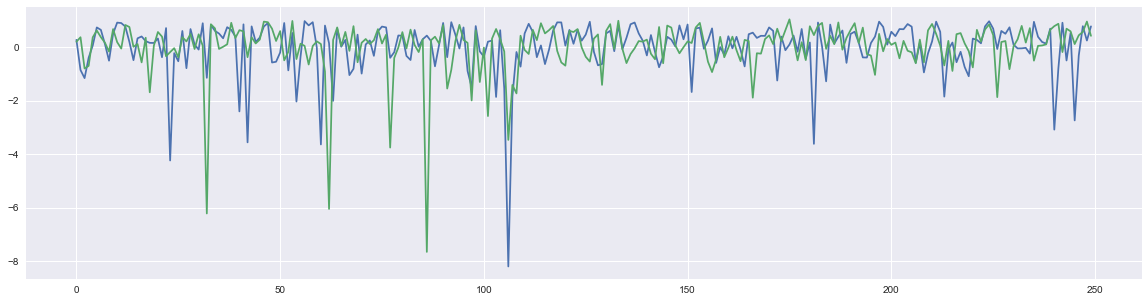

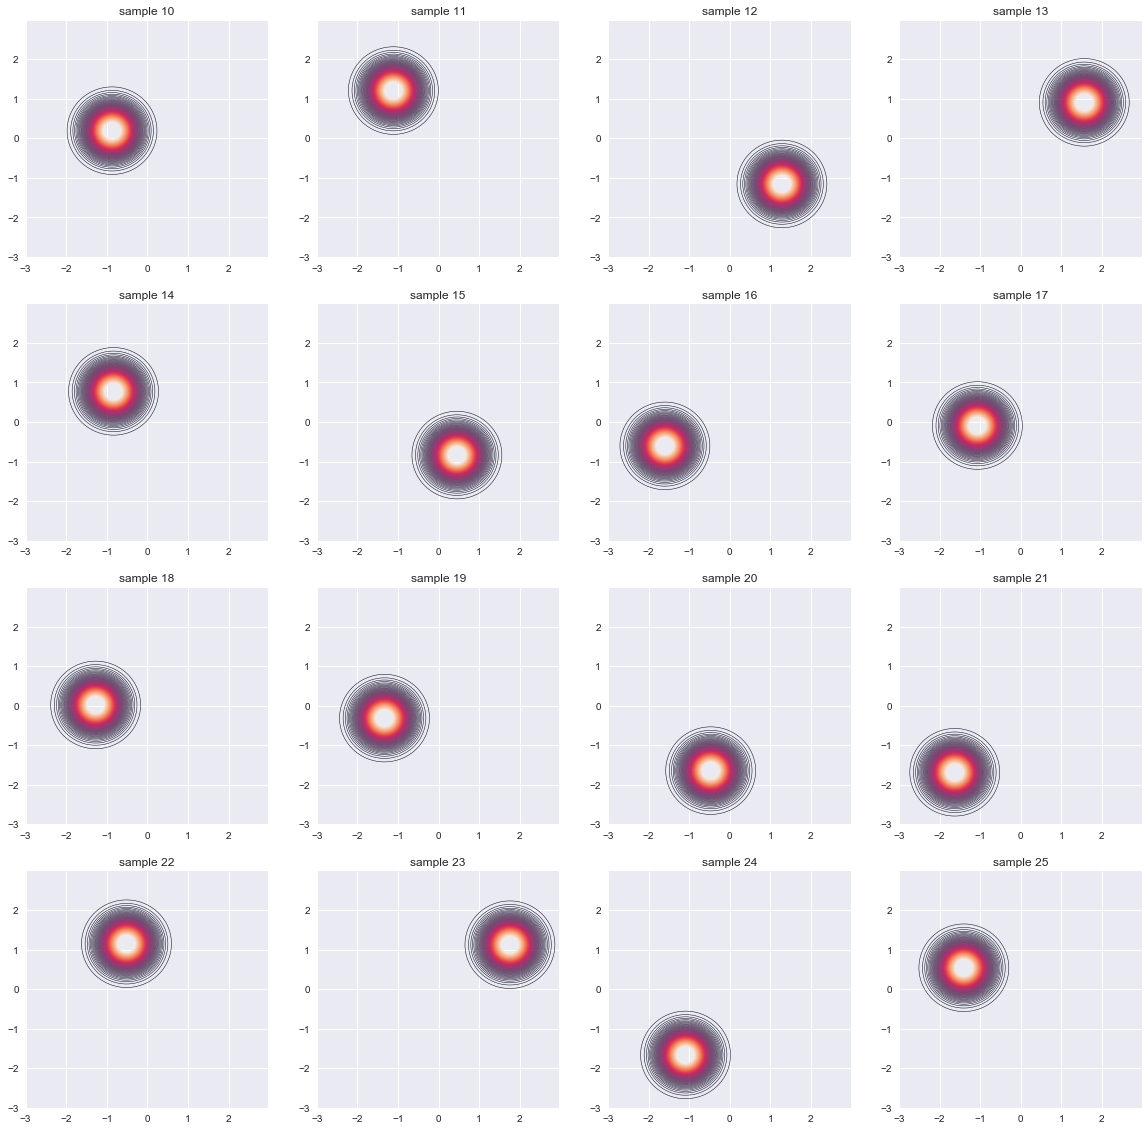

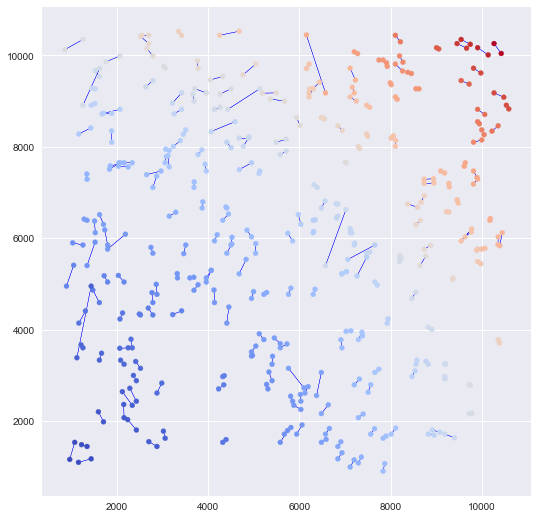

In [346]:
visual.report()
visual.plot_correlation()
visual.plot_arrows()

### check result under RMSE 200

In [2]:
from scipy.misc import imread
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
import os
load_path = 'bestparas_new/'

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
cd /Users/james/signal

/Users/james/signal


In [16]:
np.round(np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1],3)

-0.087

('batch_15_gaussian_4_datatype_toa_batch_15_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_0', 0.965429763223866)
('batch_5_gaussian_4_datatype_whole_batch_5_earlyepoch_40_nhidden_1_14_logsigma_min_max_-1_0', 0.5415162222572861)
('batch_15_gaussian_2_datatype_aoa_batch_15_earlyepoch_40_nhidden_1_26_logsigma_min_max_-1_1', 0.5886745508324686)
('batch_15_gaussian_4_datatype_toa_batch_15_earlyepoch_20_nhidden_1_26_logsigma_min_max_-2_0', 0.8976866394893034)
('batch_10_gaussian_2_datatype_data_6_batch_10_earlyepoch_40_nhidden_1_22_logsigma_min_max_-2_0', 0.9736769919790482)
('batch_10_gaussian_2_datatype_data_6_batch_10_earlyepoch_20_nhidden_1_26_logsigma_min_max_-2_1', 0.9746760822682122)
('batch_15_gaussian_4_datatype_toa_batch_15_earlyepoch_40_nhidden_1_22_logsigma_min_max_-2_1', 0.9540935562825588)
('batch_10_gaussian_6_datatype_whole_batch_10_earlyepoch_40_nhidden_1_22_logsigma_min_max_-3_0', 0.8081326460768578)
('batch_10_gaussian_4_datatype_whole_batch_10_earlyepoch_40_nhidden_1_18_

('batch_10_gaussian_2_datatype_data_6_batch_10_earlyepoch_40_nhidden_1_14_logsigma_min_max_-2_0', 0.9532957262990778)
no such file
('batch_10_gaussian_4_datatype_whole_batch_10_earlyepoch_20_nhidden_1_18_logsigma_min_max_-2_0', 0.9635868325402317)
no such file
('batch_10_gaussian_4_datatype_whole_batch_10_earlyepoch_40_nhidden_1_14_logsigma_min_max_-2_0', 0.9627701646576001)
no such file
('batch_5_gaussian_4_datatype_whole_batch_5_earlyepoch_40_nhidden_1_22_logsigma_min_max_-1_0', 0.9091330354913882)
no such file
('batch_10_gaussian_2_datatype_data_6_batch_10_earlyepoch_40_nhidden_1_30_logsigma_min_max_-2_0', 0.9446388250740305)
no such file
('batch_15_gaussian_2_datatype_whole_batch_15_earlyepoch_20_nhidden_1_10_logsigma_min_max_-2_1', 0.9679692103975024)
no such file
('batch_10_gaussian_4_datatype_whole_batch_10_earlyepoch_40_nhidden_1_26_logsigma_min_max_-2_0', 0.8866009105354326)
no such file
('batch_15_gaussian_2_datatype_whole_batch_15_earlyepoch_40_nhidden_1_14_logsigma_min_max_

('batch_5_gaussian_2_datatype_aoa_batch_5_earlyepoch_40_nhidden_1_22_logsigma_min_max_-1_0', 0.6984339268220137)
no such file
('batch_10_gaussian_2_datatype_whole_batch_10_earlyepoch_40_nhidden_1_30_logsigma_min_max_-2_1', 0.9778751846590098)
no such file
('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_20_nhidden_1_26_logsigma_min_max_-2_0', 0.8987142706408756)
no such file
('batch_10_gaussian_4_datatype_aoa_batch_10_earlyepoch_40_nhidden_1_26_logsigma_min_max_-1_1', 0.5819120473248048)
no such file
('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_0', 0.9411028274748708)
no such file
('batch_15_gaussian_2_datatype_toa_batch_15_earlyepoch_40_nhidden_1_26_logsigma_min_max_-3_0', 0.8264628310002047)
no such file
('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_40_nhidden_1_18_logsigma_min_max_-2_1', 0.9385116007569494)
no such file
('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_40_nhidden_1_10_logsigma_min_max_-2_0', 0.9040149

('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_20_nhidden_1_14_logsigma_min_max_-1_0', 0.5134069022792146)
no such file
('batch_5_gaussian_6_datatype_whole_batch_5_earlyepoch_40_nhidden_1_22_logsigma_min_max_-2_1', 0.9622597353773037)
no such file
('batch_15_gaussian_4_datatype_whole_batch_15_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_1', 0.9818739484135162)
no such file
('batch_5_gaussian_6_datatype_whole_batch_5_earlyepoch_20_nhidden_1_26_logsigma_min_max_-2_0', 0.9531433134781776)
no such file
('batch_10_gaussian_2_datatype_toa_batch_10_earlyepoch_20_nhidden_1_10_logsigma_min_max_-2_1', 0.924340434924727)
no such file
('batch_15_gaussian_4_datatype_whole_batch_15_earlyepoch_40_nhidden_1_22_logsigma_min_max_-2_0', 0.957983687478361)
no such file
('batch_5_gaussian_6_datatype_whole_batch_5_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_0', 0.9646347862906026)
no such file
('batch_10_gaussian_2_datatype_whole_batch_10_earlyepoch_40_nhidden_1_10_logsigma_min_max_-2_0', 0.663

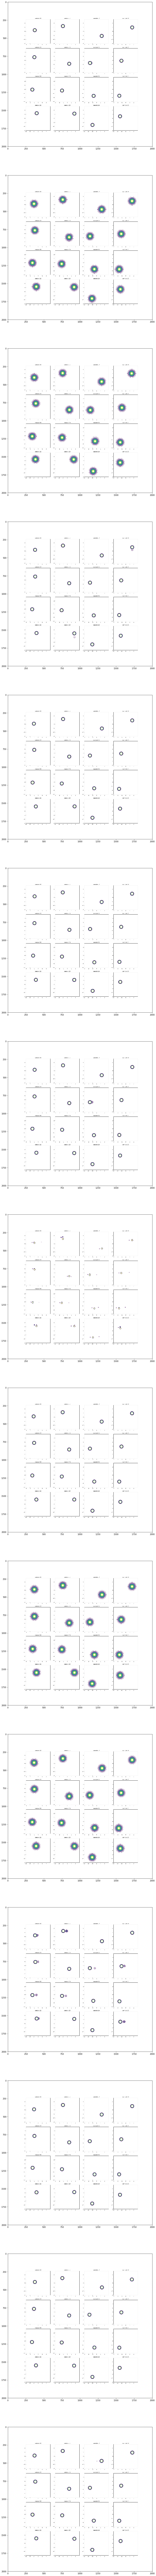

In [7]:
RMSE = []
PCC = []
fig,ax=plt.subplots(15,figsize=(16,240))
count =0
for i in os.listdir(load_path):
    try:
        RMSE.append(np.loadtxt(load_path+i+'/RMSE_PCC.txt')[0])
        PCC.append(np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1])
        if np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1]>=0.5:
            print (i,np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1])
            ax[count].imshow(imread(load_path+i+'/distribution.png'))
            count+=1
    except:
        print ('no such file')

(array([ 2.,  2.,  2.,  0.,  6.,  8., 15., 30., 39., 41., 39., 34., 39.,
        27., 35., 33., 29., 32., 28., 20., 23., 13.,  9.,  9., 14.,  5.,
         9.,  3.,  3.,  2.,  4.,  5.,  4.,  4.,  4.,  1.,  2.,  6.,  3.,
         7.,  5.,  7.,  4.,  7., 11., 12., 18., 21., 42., 57.]),
 array([-0.21690984, -0.19293416, -0.16895849, -0.14498281, -0.12100714,
        -0.09703146, -0.07305579, -0.04908011, -0.02510443, -0.00112876,
         0.02284692,  0.04682259,  0.07079827,  0.09477394,  0.11874962,
         0.1427253 ,  0.16670097,  0.19067665,  0.21465232,  0.238628  ,
         0.26260368,  0.28657935,  0.31055503,  0.3345307 ,  0.35850638,
         0.38248205,  0.40645773,  0.43043341,  0.45440908,  0.47838476,
         0.50236043,  0.52633611,  0.55031178,  0.57428746,  0.59826314,
         0.62223881,  0.64621449,  0.67019016,  0.69416584,  0.71814151,
         0.74211719,  0.76609287,  0.79006854,  0.81404422,  0.83801989,
         0.86199557,  0.88597125,  0.90994692,  0.9339226 ,

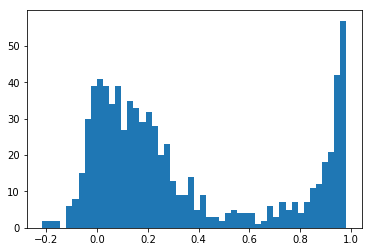

In [8]:
hist(PCC,bins=50)

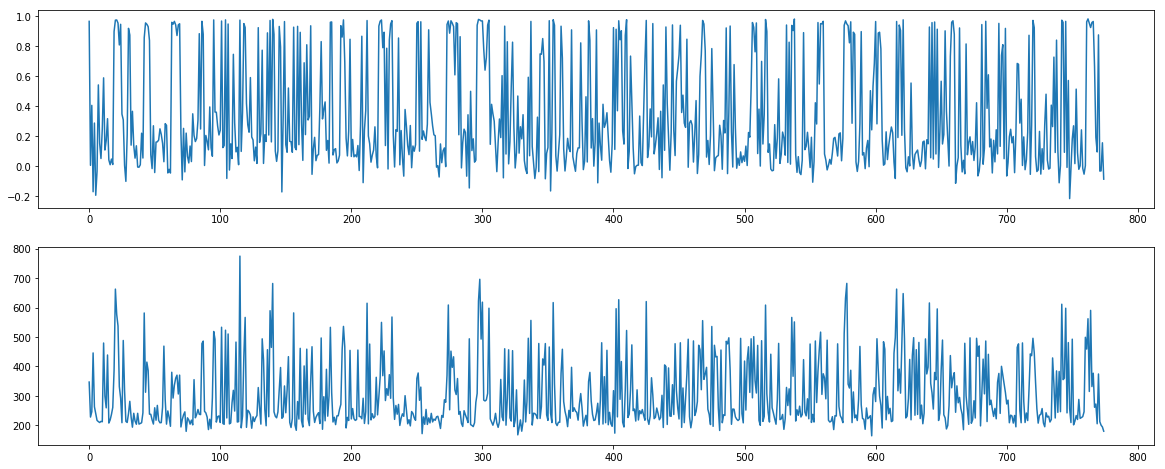

In [9]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
ax[0].plot(PCC)
ax[1].plot(RMSE)

In [12]:
pearsonr(PCC,RMSE)  
#指所有PCC（每组参数所有样本的RMSE与pmodes的相反数的pcc）与所有RMSE的相关性
#相关性强说明模型预测的好的（RMSE低的），模型对样本预测难度的把握程度也高
#可以看看哪些参数下pcc(PCC,RMSE)高

(0.5180375130497942, 1.9594660637321305e-54)

### move distribution pnd together

In [22]:
import shutil
import os
source = os.listdir("bestparas_new/")
destination = "bestparas_new_pic/"
for files in tqdm(source):
    try:
        pcctmpname = np.round(np.loadtxt('bestparas_new/'+files+'/RMSE_PCC.txt')[1],3)
        if os.path.isfile(destination+str(pcctmpname)+'_'+files+'_distribution.png'):
            print ('skip')
        else:
            shutil.copy('bestparas_new/'+files+'/distribution.png',destination)    
            os.rename(destination+'distribution.png',destination+str(pcctmpname)+'_'+files+'_distribution.png')
    except:
        print ('no such picture')

HBox(children=(IntProgress(value=0, max=776), HTML(value=u'')))

skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
no such picture
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip

### 获得不同参数的预测的每个样本的RMSE，存起来

In [52]:
RMSE_sample = {}
pmodes_sample = {}
count =0
for i in os.listdir(load_path):
    try:
        RMSE_sample[count] = np.loadtxt(load_path+i+'/RMSE_sample.txt')
        pmodes_sample[count] = np.loadtxt(load_path+i+'/pmodes_sample.txt')
        count+=1
    except:
        print ('no such file')

no such file


In [53]:
rmse_sample = np.ndarray([len(RMSE_sample),250])
pmodes_sample = np.ndarray([len(pmodes_sample),250])
for i in range(len(RMSE_sample)):
    rmse_sample[i] = RMSE_sample[i]
    pmodes_sample[i] = pmodes_sample[i]

In [54]:
rmse_sample.shape

(51, 250)

##### 在所有RMSE小于200的前提下，测试每个样本很多次RMSE的boxplot和很多次pmodes的boxplot

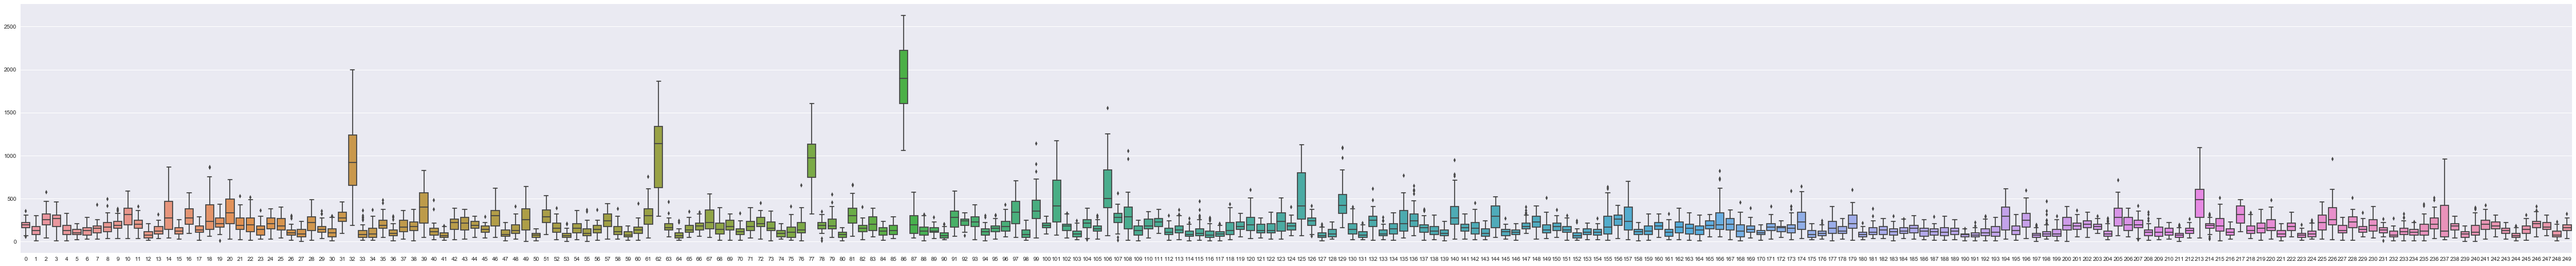

In [55]:
fig,ax=plt.subplots(1,figsize=(80,8))
sns.boxplot(data=pd.DataFrame(rmse_sample),ax=ax)
fig.savefig('plot/boxplot.png')

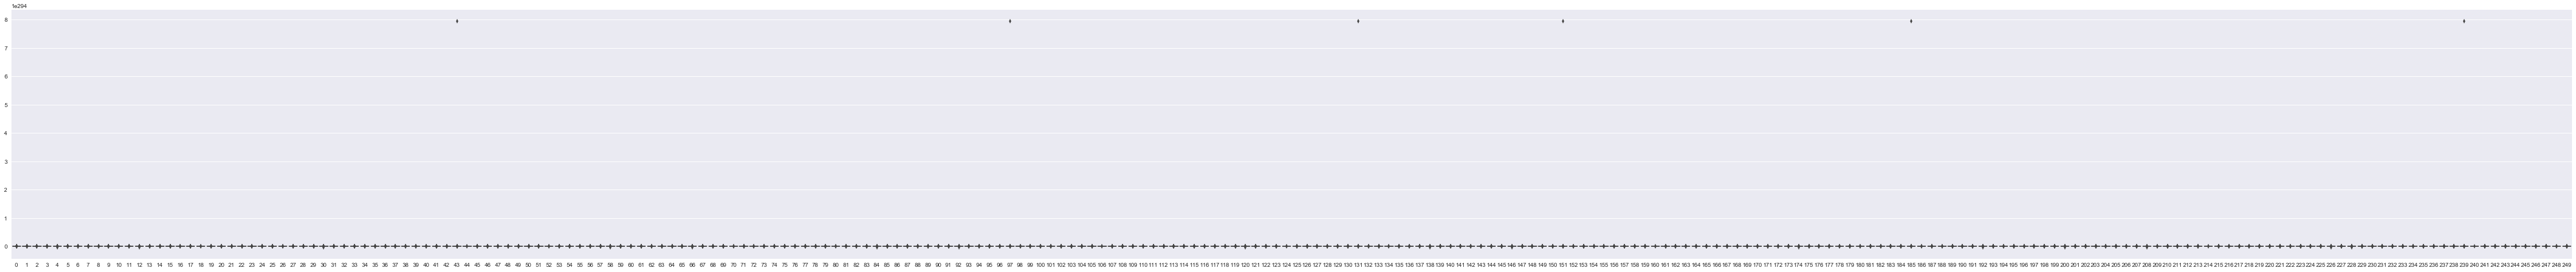

In [56]:
fig,ax=plt.subplots(1,figsize=(80,8))
sns.boxplot(data=pd.DataFrame(pmodes_sample),ax=ax)

In [48]:
pmodes_sample.ravel()

array([0.00000000e+000, 1.33509270e-307, 6.93583777e-310, ...,
       1.62448784e-320, 0.00000000e+000, 4.46569909e-309])

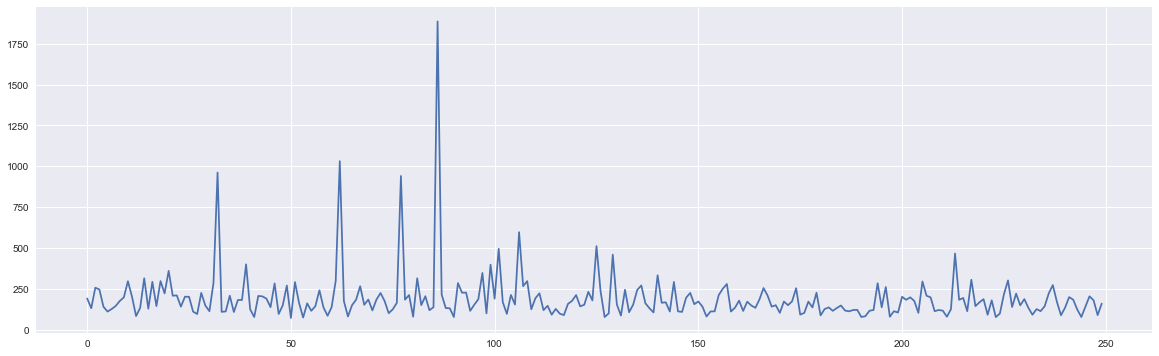

In [62]:
fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(np.average(rmse_sample,axis=0))

In [65]:
np.average(rmse_sample,axis=0)[np.argsort(np.average(rmse_sample,axis=0))[-10:]]

array([ 399.2142212 ,  458.7635935 ,  465.58629162,  494.38879857,
        510.68999172,  596.41551855,  940.14900637,  961.47037736,
       1031.00982493, 1886.91346526])

In [78]:
np.average(rmse_sample,axis=1).shape

(51,)

- 找出来一直不好的样本，去掉，重新算RMSE
#### 证明对于RMSE比较好的结果中，去掉比较差的几个样本，通常可以获得20左右的RMSE的提升

In [79]:
np.average(rmse_sample,axis=1) - np.average(np.delete(rmse_sample,np.argsort(np.average(rmse_sample,axis=0))[-10:],axis=1),axis=1)

array([22.64684986, 16.81124806, 27.6142013 , 20.90020089, 23.83951553,
       26.32839198, 20.41586686, 25.94102972, 24.95450333, 20.43964865,
       23.9085702 , 21.83563753, 28.52543957, 21.94422168, 22.32987014,
       28.32151558, 33.9159864 , 27.53745891, 22.94577371, 24.8711534 ,
       24.4695951 , 24.06851694, 27.32695337, 20.13538936, 22.86674433,
       23.59999328, 23.51441915, 29.4625503 , 27.71221884, 26.46526044,
       22.33835843, 20.75977303, 23.66268732, 27.11900849, 20.00636023,
       24.29086212, 28.13527724, 21.65629289, 24.95566842, 26.07502661,
       25.14404308, 24.00300767, 24.16694617, 26.6039084 , 24.03107738,
       17.83104552, 22.29739884, 26.06182031, 25.2264956 , 25.50363801,
       25.05987962])

##### 在所有RMSE小于200的前提下且PCC大于0.8，测试每个样本很多次RMSE的boxplot和很多次pmodes的boxplot

- 在比较好的p_modes和RMSE的pcc中，是否能一致地通过pmodes发现这些用RMSE定义出来的差样本？

In [85]:
#后续如何确定R也是个问题，如何知道要找多大范围的R呢，对于不同过得分布R如何公平？
R =2
def get_circle(R=0.05,center=[m,n],scale=0.001):
    #分别产生x和y的方阵，算每个点的距圆心距离，只要符合要求的# R is the radius
    for x in np.arange(m-R,m+R,scale):
        
        
    for y in np.arange(n-R,n+R,scale):
        
        
        Y = int((R*R-x*x)**0.5) # bound for y given x
        for y in range(-Y,Y+1):
            yield x,y

In [86]:
a,b = get_circle(10)

ValueError: too many values to unpack

进一步确定参数，测试不同type
batch 5
gaussian 2 4 8  16
early 40
hidden 28
-1
1

In [ ]:
#!/bin/bash
# add all other SBATCH directives here...

#SBATCH -p cox
#SBATCH --gres=gpu:0
#SBATCH --constraint=titanx
#SBATCH -n 1  # Number of cores
#SBATCH -N 1 # Ensure that all cores are on one machine
#SBATCH --mem=1000
#SBATCH -t 1-00:00:00
#SBATCH -o logs/train_%j.log
#SBATCH -e logs/signal1.err # STDERR

COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 2 16)
    do
        for batch in $(seq 5 5 15)
        do
            for early_epoch in $(seq 20 20 40)
            do
                for logsigmamin in $(seq -3 -1)
                do
                    for logsigmamax in $(seq 0 1)
                    do
                        for nhidden1 in $(seq 6 4 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python bin/test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER

精细确定参数后，测七种数据，存在models_new test_parameters_.py 

### 后续思路
- [x] 改成zscore
- [x] pi加限制，加pseudocount 基本解决nan问题

- 研究各个参数
- 大规模测试参数： RMSE作为衡量指标
    - 用哪些数据集
    - sigma 范围
    - Gaussian数量
    - MLP网络相关参数
        - layer
        - activation...
- 观察参数和结果的规律

- loss下降与结果好相关不强，极值点的pdf过小，总体太平均了
- 考虑研究数据本身的特征
- outlier：距离差大的是不是不确定度也大
    - 看看误差大的样本是不是不确定度也大，如果真的相关性强的话，那我们就找到了一个很好的方法来衡量样本的预测难度
- 借鉴bishop的一些绘图思路，可视化出来probablity
- 生成二维分布时是否可以考虑$\rho$
- 观察数据分布，分析
- 其他
- 可以画类似一维置信区间的二维置信区域图
- VAE
- 如果训练时候可以训练一段时间然后得到p modes筛除掉不可信样本再训练，结果是否可以提升   
- 能否指示不好预测的样本，能否指示应该用你哪些特征？
- 单独分析不好预测的样本？有没有哪些样本在很多模型都不好预测？
- RMSE不高但是其他条件好的样本也值得考虑，也许可以挑出来不好的样本，重新训练等，能够找样本很重要